In [79]:
#print sigmoid 

In [80]:
import matplotlib.pyplot as plt
import numpy as np

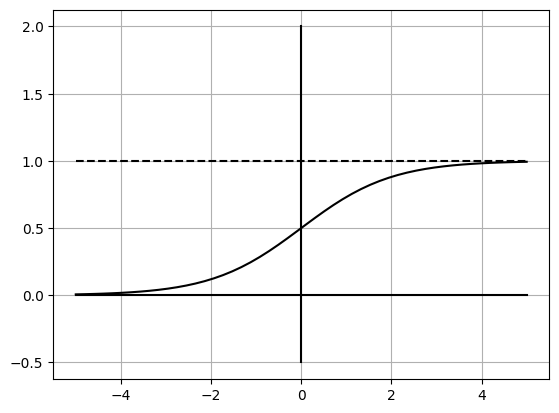

In [81]:
x = np.linspace(-5 , 5)
y = 1/(1 + np.exp(-x))

plt.plot( x , y , "k-")
plt.plot([-5 , 5] , [0 , 0] , "k-")
plt.plot([0 , 0] , [-0.5 , 2] , "k-")
plt.plot([-5 , 5] , [1 , 1] , "k--")
plt.grid()


In [82]:
#kaimingi init 
# removing the scaling down by root 5

import torch 
import torch.nn as nn

In [83]:
import torchmetrics

In [84]:
layer = nn.Linear(40, 10)
layer.weight.data *= 6 ** 0.5
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [85]:
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [86]:
#i.e initializing weights using kaiming unifrom and bias with 0 

In [87]:
# # DYING RELU : 

# IT OCCURS WEHN WE HAVE SAY NEGATIVE OR ZERO OUTPUT NEURON GIVE TO THE RELU SO IT OUTPUTS 0 
# WHICH MEANS VANISHSING GRAD SO THE WEIGHT WONT TWEAK AND THE NEURON WILL CONTINUOUSLY INPUT 0 CUZ NO WEIGHT TWEAK 
# HENCE BECOME DEAD 

In [88]:
def plot_leakyRelu(alpha = 0.2):
    x = np.linspace(-5 , 5 , 100)
    y = np.maximum(alpha*x , x)
    plt.plot(x , y , "r-" , label=r"leaky relu : $max(\alpha z , z) $" , linewidth = 2)
    plt.grid()
    plt.legend(loc="upper left", fontsize=10 )
    plt.axhline(0 , color="black")
    plt.axvline(0 , color="black")

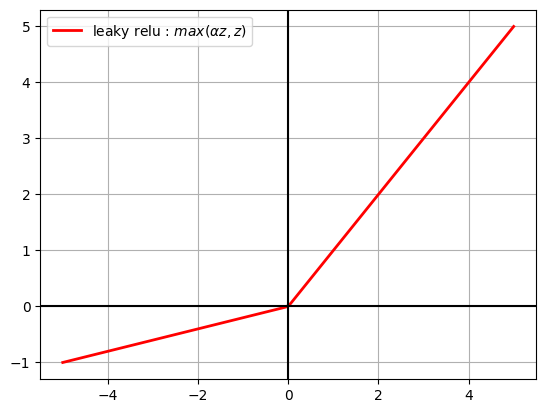

In [89]:
plot_leakyRelu()

In [90]:
def Elu(x , alpha = 1):
    return np.where( x < 0 , alpha * (np.exp(x) - 1) , x)

def SElu(x):
    return 1.05 * Elu(x , alpha=1.67)


def plot_smooth_relu_varient(alpha = 1):
    x = np.linspace(-5 , 5 , 100)
    y_elu = Elu(x)
    y_selu = SElu(x)
    plt.plot(x , y_elu , "b-" , label=r"$ Elu_{\alpha}(z) =  \alpha( \exp^{x} - 1) \text{ if z< 0 , else z }$" , linewidth = 2)
    plt.plot(x , y_selu  , "r-" , label=r"Selu(z) = $ 1.05 ELU_{1.67}(z)$" , linewidth = 2)
    plt.grid()
    plt.legend(loc="upper left", fontsize=14 )
    plt.axhline(0 , color="black")
    plt.axvline(0 , color="black")

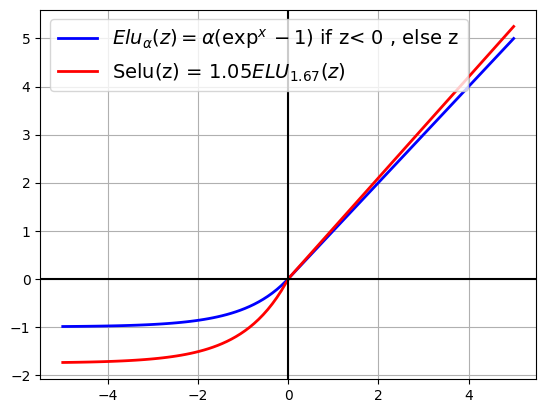

In [91]:
plot_smooth_relu_varient()

In [92]:
# BATCH NORMALIZATION 

In [93]:
#using batch normalization on fashion mnist 

In [94]:
import torchvision 
import torchvision.transforms.v2 as T 
from torch.utils.data import DataLoader , TensorDataset
import torchmetrics

In [95]:
toTensor = T.Compose([T.ToImage() , T.ToDtype(torch.float32 , scale=True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root="datasets" , train=True , transform=toTensor , download=True
)

test_data = torchvision.datasets.FashionMNIST(
    root="datasets" , train=False , download=True , transform=toTensor
)

In [96]:
len(train_and_valid_data)

60000

In [97]:
train_data , valid__data = torch.utils.data.random_split(
    train_and_valid_data , [55000 , 5000]
)

In [98]:
train_dataset = DataLoader(train_data , batch_size = 1024 , shuffle= True , pin_memory=True , 
                           num_workers=4 , persistent_workers=True)

val_dataset = DataLoader(valid__data , batch_size = 1024 , shuffle= True , pin_memory=True , 
                           num_workers=4 , persistent_workers=True)

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Your device is {device}")

def eval(model , metric , val_loader):
    model.eval()
    metric.reset()
    
    with torch.no_grad():
        for x_batch , y_batch in val_loader:
            x_batch , y_batch = x_batch.to(device) , y_batch.to(device)
            
            y_pred = model(x_batch)
            
            metric.update(y_pred , y_batch)
            
    return metric.compute()





def train_eval(model , train_loader , criterion , optimizer ,
               val_loader , metric , n_epoch ):
    
    history = {"train_loss" : [] , "train_metric(accuracy)" : [] , "val_metric(accuracy)" : []}

    for epoch in range(n_epoch):
        model.train()
        metric.reset()
        total_loss = 0
        for x_batch , y_batch in train_loader:
            #data
            x_batch , y_batch = x_batch.to(device) , y_batch.to(device)
            
            #forward
            
            y_pred  = model(x_batch)
            
            #loss 
            
            loss = criterion(y_pred , y_batch)
            total_loss += loss.item()
            
            #optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            metric.update(y_pred , y_batch)
            
        loss_mean = total_loss/len(train_loader)
        
        history["train_loss"].append(loss_mean)
        history["train_metric(accuracy)"].append(metric.compute().item())
        
        history["val_metric(accuracy)"].append(eval(model , metric , val_loader).item())
        
        print(f"Epoch : {epoch + 1}/{n_epoch}, "
              f"Train Loss : {history['train_loss'][-1]}, "
              f"Train Metric ( Accuracy) : {history['train_metric(accuracy)'][-1]}, "
              f"Val Metric (accuracy) : {history['val_metric(accuracy)'][-1]}")
        
        
    return history
            

Your device is cuda


In [100]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

In [101]:
torch.manual_seed(42)
model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1 * 28 * 28),
    nn.Linear(1 * 28 * 28 , 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300 , 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100 , 10)
).to(device)

optimizer = torch.optim.SGD(model.parameters() , lr=0.008471801418819975 , momentum=0)

sentropy = nn.CrossEntropyLoss()

accuracy_metric = torchmetrics.Accuracy(task='multiclass' , num_classes=10).to(device)

# uncomment for training

# _ = train_eval(model , train_dataset , sentropy , optimizer ,
#                val_dataset , accuracy_metric , 20)


In [102]:
torch.manual_seed(42)
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28 , 300 , bias=False),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Linear(300 , 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100 , 10)
    
).to(device)

optimizer = torch.optim.SGD(model.parameters() , lr=0.008471801418819975 , momentum=0)

sentropy = nn.CrossEntropyLoss()

accuracy_metric = torchmetrics.Accuracy(task='multiclass' , num_classes=10).to(device)

#uncomment for training 

# _ = train_eval(model , train_dataset , sentropy , optimizer ,
#                val_dataset , accuracy_metric , 20)


In [103]:
#layer normalization on random rgb images

In [104]:
inputs = torch.randn(32 , 3 , 100 , 200)
layer_norm = nn.LayerNorm([100, 200])
result = layer_norm(inputs)

In [105]:
#across all channels

inputs = torch.randn(32 , 3 , 100 , 200)
layer_norm = nn.LayerNorm([3 , 100, 200])
result = layer_norm(inputs)

In [106]:
# transfer training 

In [107]:
from sklearn.datasets import fetch_openml
fashion_mnist = fetch_openml(name = "Fashion-MNIST" , as_frame=False)

In [108]:
print(fashion_mnist.DESCR)

**Author**: Han Xiao, Kashif Rasul, Roland Vollgraf  
**Source**: [Zalando Research](https://github.com/zalandoresearch/fashion-mnist)  
**Please cite**: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747  

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

Raw data available at: https://github.com/zalandoresearch/fashion-mnist

### Target classes
Each training and test example is assigned to one of the following labels:
Label  Description  
0  T-shirt/top  
1  Trouser  
2  Pullover  
3  Dress  
4  

In [109]:
type(fashion_mnist.target)

numpy.ndarray

In [110]:
print(fashion_mnist.target.dtype)

object


In [111]:
# data trimming 

x = torch.FloatTensor(fashion_mnist.data.reshape(-1 , 1 , 28 , 28)/ 255.) 
y = torch.from_numpy(fashion_mnist.target.astype(int))

in_b = (y == 0) | (y == 2)
x_a , x_b = x[~in_b] , x[in_b]
y_a , y_b = y[~in_b] , (y[in_b] == 2).to(dtype=torch.float32).view(-1 , 1)
y_a = torch.maximum(y_a - 2 , torch.tensor(0))



In [112]:
print(x_a.shape , x_b.shape)

torch.Size([56000, 1, 28, 28]) torch.Size([14000, 1, 28, 28])


In [113]:
trian_set_a = TensorDataset(x_a[: - 7_000] , y_a[: -7_000])
valid_set_a = TensorDataset(x_a[-7_000 : -5_000] , y_a[-7_000: - 5_000])
test_set_a = TensorDataset(x_a[-5_000 :] , y_a[-5_000:])

train_set_b = TensorDataset(x_b[:20] , y_b[:20])
valid_set_b = TensorDataset(x_b[20 : 5_000] , y_b[20 : 5_000])
test_set_b = TensorDataset(x_b[5_000 :] , y_b[5_000 : ])

In [114]:
data_loader_train_a = DataLoader(trian_set_a , batch_size = 32 , shuffle=True , 
                                 num_workers=4 , persistent_workers=True , pin_memory=True)
data_loader_val_a = DataLoader(valid_set_a , batch_size = 32 , shuffle=True , 
                                 num_workers=4 , persistent_workers=True , pin_memory=True)
data_loader_test_a = DataLoader(test_set_a , batch_size = 32 , shuffle=True , 
                                 num_workers=4 , persistent_workers=True , pin_memory=True)

data_loader_train_b = DataLoader(train_set_b , batch_size = 32 , shuffle=True , 
                                 num_workers=4 , persistent_workers=True , pin_memory=True)
data_loader_val_b = DataLoader(valid_set_b , batch_size = 32 , shuffle=True , 
                                 num_workers=4 , persistent_workers=True , pin_memory=True)
data_loader_test_b = DataLoader(test_set_b , batch_size = 32 , shuffle=True , 
                                 num_workers=4 , persistent_workers=True , pin_memory=True)

In [115]:
torch.manual_seed(42)
model_A = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28 , 100),
    nn.ReLU(),
    nn.Linear(100 , 100),
    nn.ReLU(),
    nn.Linear(100 , 100),
    nn.ReLU(),
    nn.Linear(100 , 8)
).to(device)

model_A.apply(use_he_init)

optimizer = torch.optim.SGD(model_A.parameters() , lr=0.005)
criterion = nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass' , num_classes=8).to(device)


In [116]:
# history_a = train_eval(model_A , data_loader_train_a , criterion , optimizer ,
#            data_loader_val_a , metric , 20)

In [ ]:
#normal model b 

torch.manual_seed(9)

model_B = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
).to(device)

optimizer = torch.optim.SGD(model_B.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train_eval(model_B , data_loader_train_b , criterion , optimizer ,
           data_loader_val_b , metric , 20)

In [ ]:
# resuse model a layers except the top layer for model b 

In [ ]:
import copy 
torch.manual_seed(42)
reused_layers = copy.deepcopy(model_A[:-1])
model_B_on_A = nn.Sequential(
    *reused_layers,
    nn.Linear(100 , 1) # output layer for b 
).to(device)